<a href="https://colab.research.google.com/github/rashidmeras/EVA_PHASE1/blob/master/Rerun_of_EVA_S6_Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA (M6) Session6 Assignment 6B (Re-Runs): 

Objective:

> Using the network defined in Assignment 6A change the code to include:

> * Normal Convolution
> * Separable Convolution 
> * Depthwise Convolution
> * Grouped Convolution (use 3x3, 5x5 only)
> * Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

Must use all of the 5 above at least once and train this new model for 50 epochs. 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(900) 
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D
from keras.layers import Conv2D, Activation, Flatten, Dropout, Input, Lambda, Dense, Add
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras.layers.merge import concatenate
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import ReLU

# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

Using TensorFlow backend.


In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


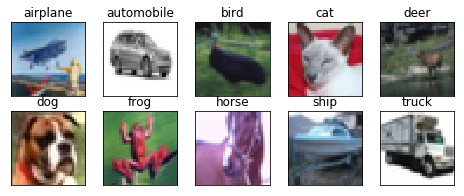

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##Image Normalization

In [7]:

batch_size = 128

# standardize images
def prep_standardize(train, test):
	# convert from integers to floats
	train_stan = train.astype('float32')
	test_stan  = test.astype('float32')
	# calculate statistics
	m = train_stan.mean()
	s = train_stan.std()
	# center datasets
	train_stan = (train_stan - m) / s
	test_stan  = (test_stan - m) / s
	# return normalized images
	return train_stan, test_stan

train_features, test_features = prep_standardize(train_features, test_features)

# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (train_features.min(), train_features.max()))
print('Test min=%.3f, max=%.3f' % (test_features.min(), test_features.max()))

Train min=-1.882, max=2.093
Test min=-1.882, max=2.093


## Functional Network

In [8]:
# Function for common layer
def add_common_layers(y):
    y = BatchNormalization()(y)
    y = ReLU()(y)  
    y = Dropout(0.1)(y)
    
    return y

def space_to_depth_x2(x):
    return tf.space_to_depth(x, block_size=2)  

# Define the network  
img_height = 32
img_width = 32
channel = 3
  
input = Input(shape=(img_height, img_width, channel))

#===> 1) Normal Convolution
x = Conv2D(32, (3,3), use_bias=False, padding='same', name='L1_Norm_Conv')(input)
x = add_common_layers(x)


#===> 2) Spatially Speprable Convolution
x = Conv2D(32, (1, 3), use_bias=False, activation='relu', name='L2Spat_Sep_Conv1')(x)
x = Conv2D(32, (3, 1), use_bias=False, activation='relu', name='L2_Spat_Sep_Conv2')(x)

x = Conv2D(32, (3,3), use_bias=False, name='L3_Norm_Conv')(x)
x = add_common_layers(x)

#===> 3) Depthwise Seperable Convolution
x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='L4_Dep_Sep_Conv')(x)
x = add_common_layers(x)

#skip from here
skip_connection = x

# Max-Pooling layer
x = MaxPooling2D(pool_size=(2, 2))(x)

#===> 4) Grouped Convolution (use 3x3, 5x5 only)
x1 = Conv2D(64, (3, 3), padding='same', use_bias=False, name='block0_GroupConv1')(x)
x1 = add_common_layers(x1)
x2 = Conv2D(64, (5, 5), padding='same', use_bias=False, name='block0_GroupConv2')(x)
x2 = add_common_layers(x2)

skip_connection = Conv2D(64, (3, 3), padding='same', use_bias=False, name='L5_Norm_Conv')(skip_connection)
skip_connection = add_common_layers(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)
  
x = concatenate([x1, x2, skip_connection, x])

#===> 5) Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 
x1 = Conv2D(64, (3, 3), padding='same', dilation_rate=1, activation='relu', use_bias=False, name='block1_GroupConv1')(x)
x2 = Conv2D(64, (3, 3), padding='same', dilation_rate=2, activation='relu', use_bias=False, name='block1_GroupConv2')(x)
  
x = concatenate([x1, x2, x])

# ===> 6) Final: Flatten, Activation
x = Conv2D(10, (7, 7), use_bias=False, name='L7_Norm_Conv')(x)
x = add_common_layers(x)
x = Conv2D(10, (8, 8), use_bias=False, name='L8_Norm_Conv')(x)

flat_layer = Flatten()(x)
output = Activation('softmax')(flat_layer)

model = Model(inputs=[input], outputs=[output])
model.summary()

# plot model architecture
plot_model(model, show_shapes=True, to_file='Assignment_6B_Network.png')

W0616 15:21:12.868812 140362443777920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 15:21:12.903215 140362443777920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 15:21:12.910449 140362443777920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 15:21:12.944332 140362443777920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0616 15:21:12.946376 1403624437

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L1_Norm_Conv (Conv2D)           (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         L1_Norm_Conv[0][0]               
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

##Visualizing the network architecture:

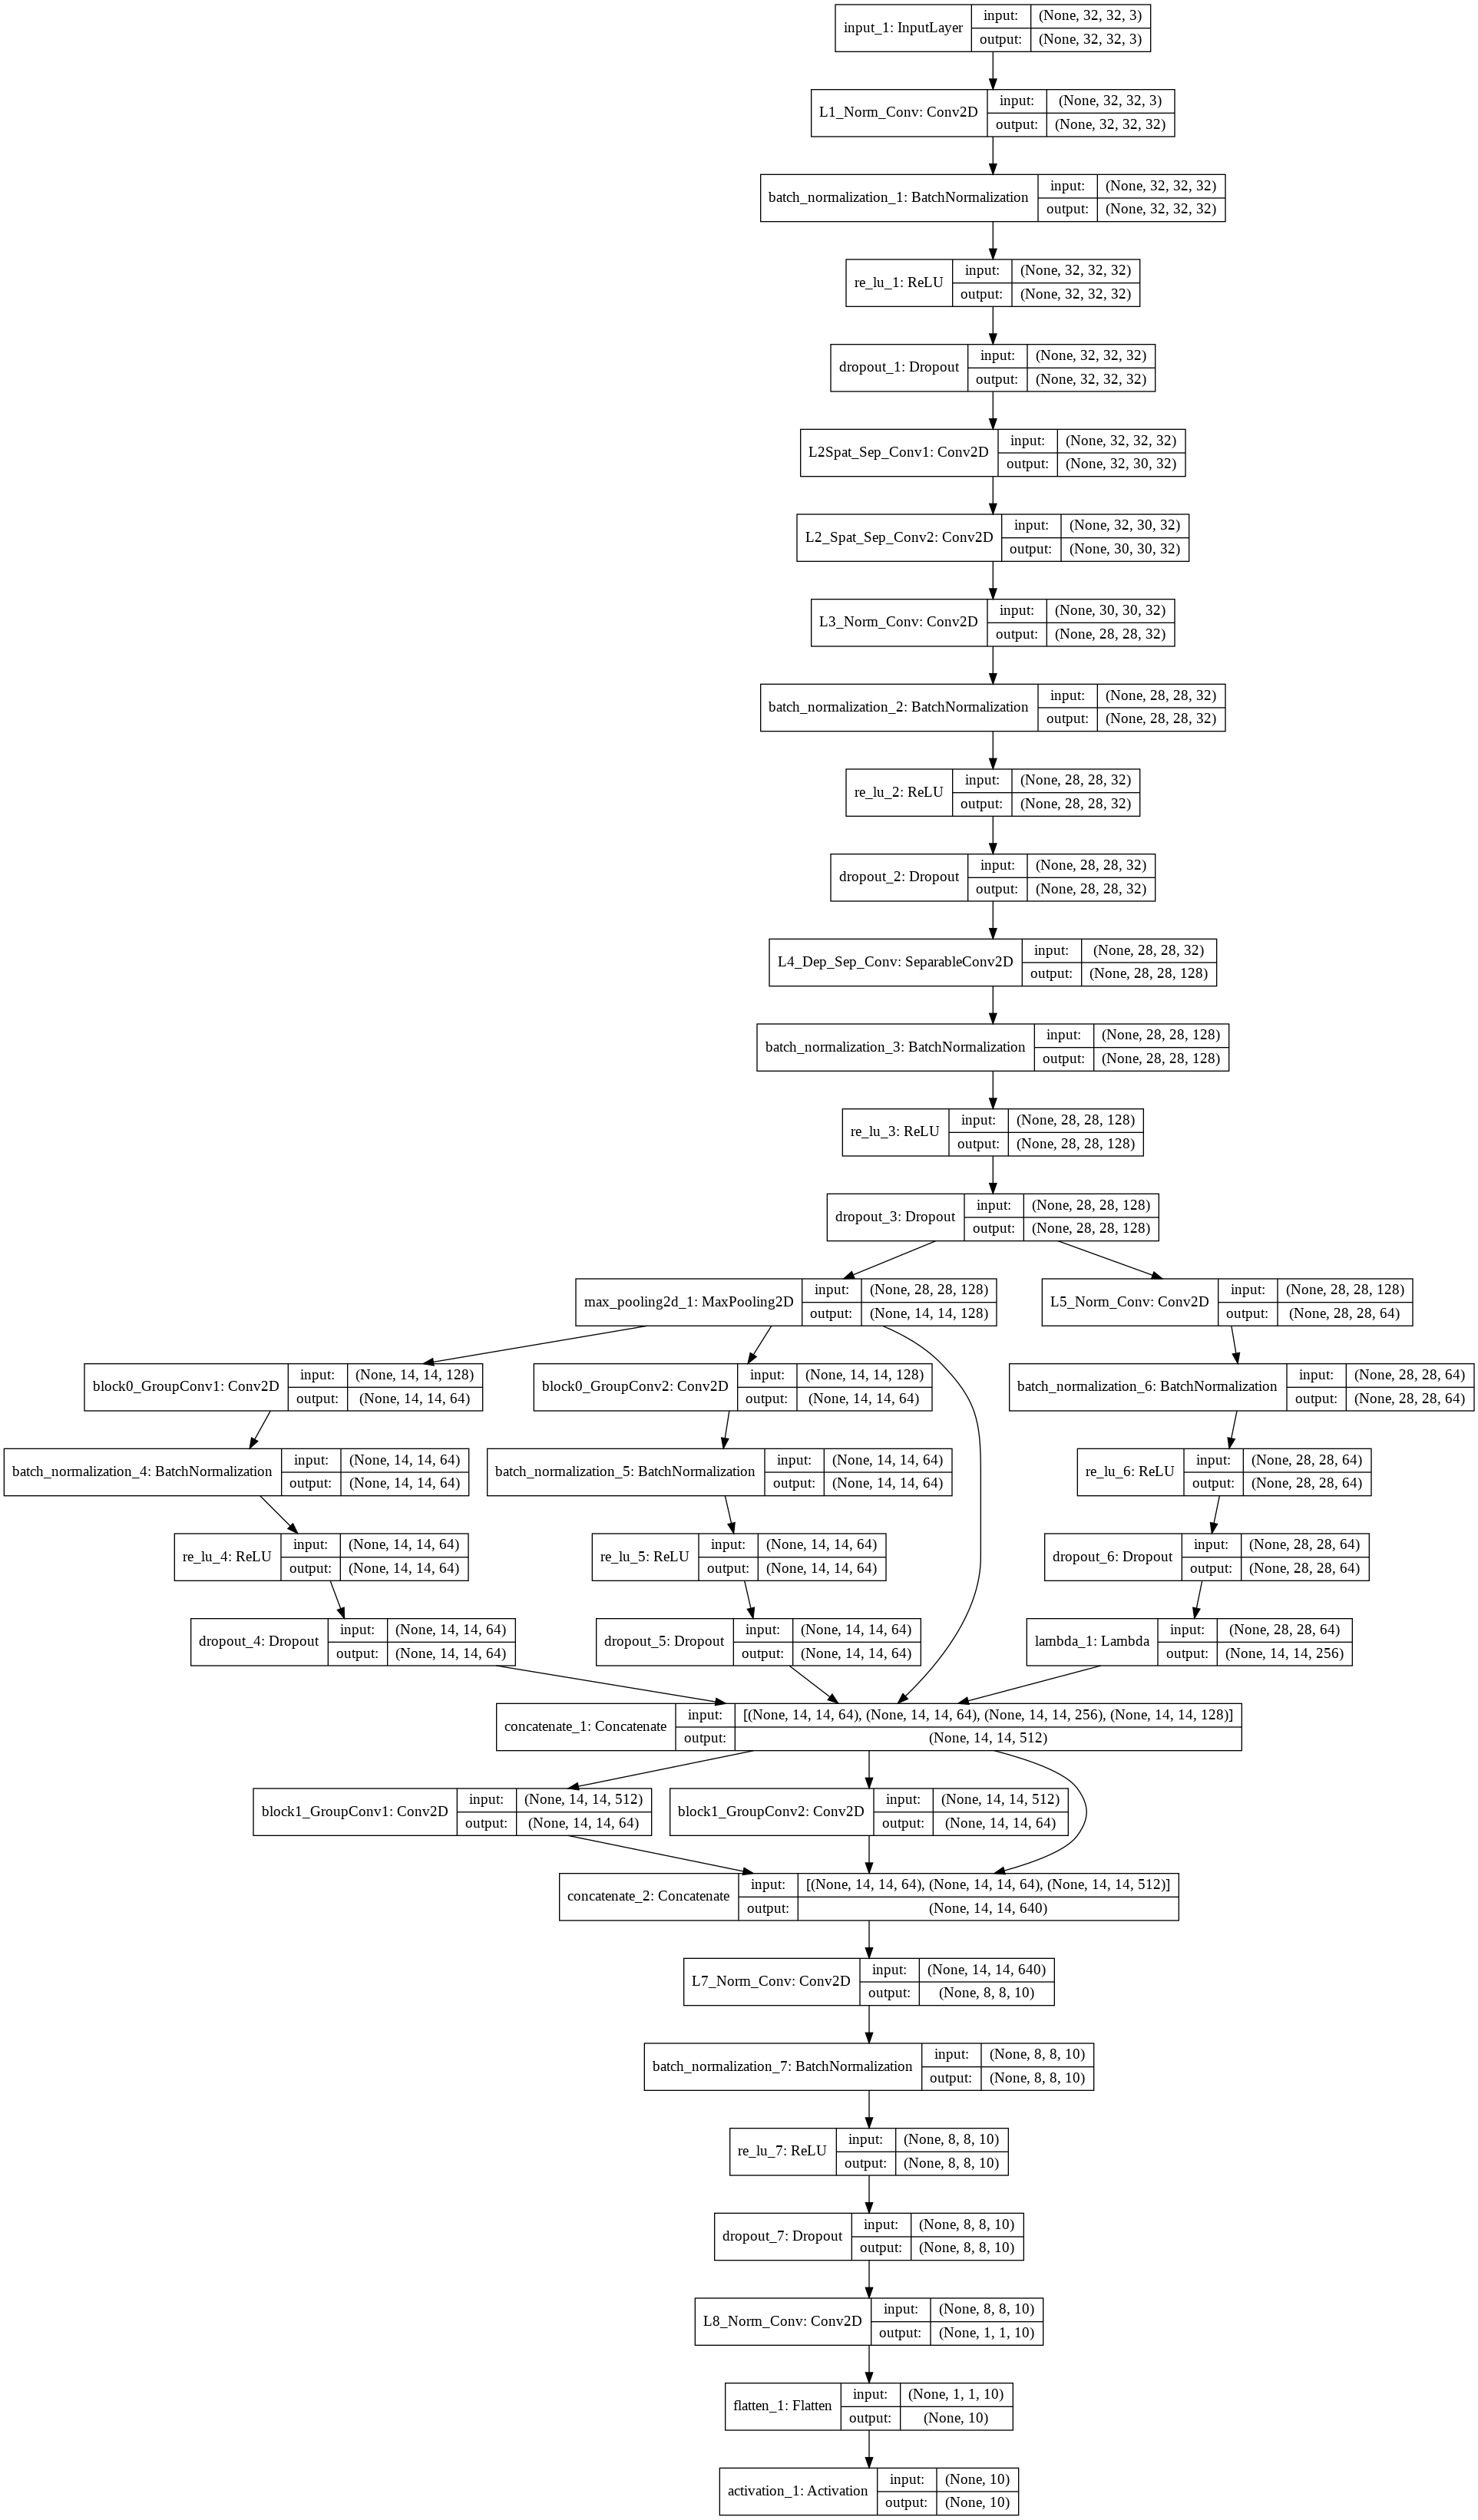

In [9]:
from IPython.display import Image
Image(retina=True, filename='Assignment_6B_Network.png')

## Run 1
Date: 16/06/2019

W0616 15:21:16.937282 140362443777920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 15:21:16.953626 140362443777920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 42s 840us/step - loss: 0.2226 - acc: 0.9147 - val_loss: 0.2341 - val_acc: 0.9125

Epoch 00001: val_acc improved from -inf to 0.91248, saving model to best_new_model.h5
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 748us/step - loss: 0.1663 - acc: 0.9348 - val_loss: 0.1698 - val_acc: 0.9345

Epoch 00002: val_acc improved from 0.91248 to 0.93450, saving model to best_new_model.h5
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 38s 750us/step - loss: 0.1405 - acc: 0.9447 - val_loss: 0.2093 - val_acc: 0.9240

Epoch 00003: val_acc did not improve from 0.93450
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [=================

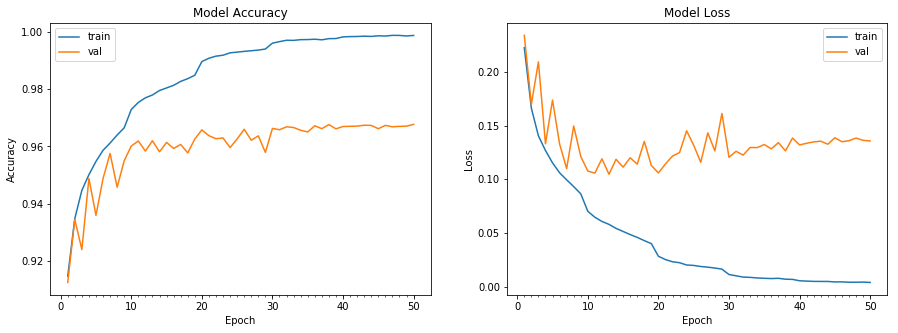

Accuracy on test data is: 83.54


In [10]:
import math
import numpy as np
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

# Define custom loss
def custom_loss(actual,predicted):
    sqr_w = 0
    lamda = 1e-2
    
    for layer in model.layers:
       sqr_w = sqr_w + np.sum(np.sum(np.sum(np.square(layer.get_weights()))))
        
    l2_regularization = (lamda*sqr_w)/2*(batch_size)    
    loss = K.binary_crossentropy(actual,predicted) + l2_regularization
    # Return a function
    return loss

sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)
  
model.compile(optimizer= sgd,
#               loss = custom_loss,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_new_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# train the model
start = time.time()

# Train the model
history = model.fit(train_features,       
                    train_labels,
                    batch_size=batch_size,
                    epochs=50,                  
                    validation_data=(test_features, test_labels),
                    callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                    verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Run2:


Train on 50000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 750us/step - loss: 0.0728 - acc: 0.9737 - val_loss: 0.1550 - val_acc: 0.9516

Epoch 00001: val_acc did not improve from 0.96773
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 38s 752us/step - loss: 0.0456 - acc: 0.9823 - val_loss: 0.1561 - val_acc: 0.9517

Epoch 00002: val_acc did not improve from 0.96773
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 747us/step - loss: 0.0409 - acc: 0.9844 - val_loss: 0.1690 - val_acc: 0.9504

Epoch 00003: val_acc did not improve from 0.96773
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 38s 750us/step - loss: 0.0361 - acc: 0.9862 - val_loss: 0.

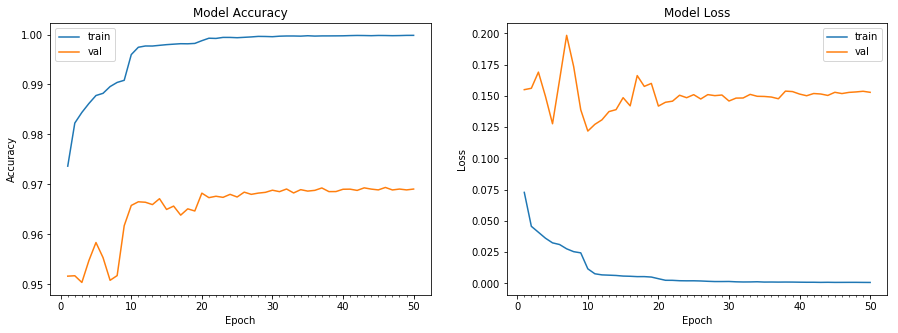

Accuracy on test data is: 84.34
2019-06-16 16:31:24.094109


In [11]:
# train the model
start = time.time()

# Train the model
history = model.fit(train_features,       
                    train_labels,
                    batch_size=batch_size,
                    epochs=50,                  
                    validation_data=(test_features, test_labels),
                    callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                    verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

import datetime
print(datetime.datetime.now())

## Run3

Train on 50000 samples, validate on 10000 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 38s 756us/step - loss: 0.0284 - acc: 0.9900 - val_loss: 0.1466 - val_acc: 0.9612

Epoch 00001: val_acc did not improve from 0.96939
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 739us/step - loss: 0.0199 - acc: 0.9925 - val_loss: 0.1510 - val_acc: 0.9605

Epoch 00002: val_acc did not improve from 0.96939
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 747us/step - loss: 0.0172 - acc: 0.9936 - val_loss: 0.1630 - val_acc: 0.9604

Epoch 00003: val_acc did not improve from 0.96939
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.1.
50000/50000 [==============================] - 37s 743us/step - loss: 0.0163 - acc: 0.9940 - val_loss: 0.

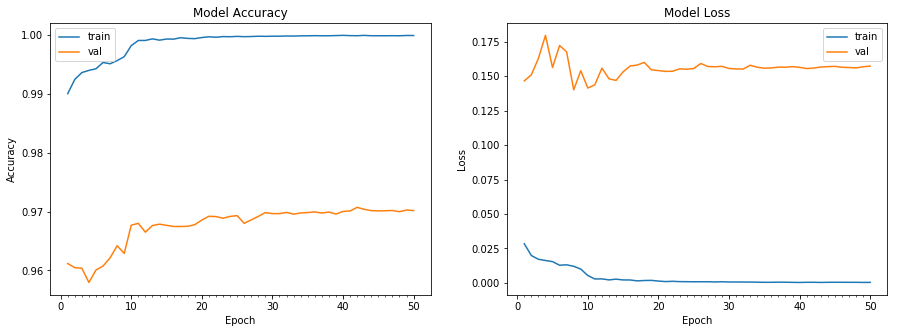

Accuracy on test data is: 84.99
2019-06-16 17:13:14.777557


In [12]:
# train the model
start = time.time()

# Train the model
history = model.fit(train_features,       
                    train_labels,
                    batch_size=batch_size,
                    epochs=50,                  
                    validation_data=(test_features, test_labels),
                    callbacks=[save_mcp, LearningRateScheduler(step_decay, verbose=1)], 
                    verbose=1)


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(history)

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

import datetime
print(datetime.datetime.now())

##Summary:



A new network using Functional API  in impelemented using Normal Convolution, Separable Convolution, Depthwise Convolution and Grouped Convolution with different kernel sizes. The network was trained from 50 epochs, the total prameters of the network and validation accuracy is as mentioned below:


> * Total params: 1,284,264
> * Trainable params: 1,283,476
> * Non-trainable params: 788
> > *  Base: Validation Accuracy: **96.68%**
> > *  Run1: Validation Accuracy: **96.773%**
> > *  Run2: Validation Accuracy: **96.939%**
> > *  Run3: Validation Accuracy: **97.073%**


Thank you!